# Plotting PyPSA results


This notebooks shows some techniques which can be useful to investigate results of the model run. You will need a solved network model for a given country which can be obtained by running the whole workflow with `snakemake -j 1 solve_all_networks`. To set the country please use `countries` variable in the `config.yaml` file. The results bellow were obtained for Nigeria with the following settings

```python
scenario:
  simpl: ['']
  ll: ['copt']
  clusters: [10]
  opts: [Co2L-3H]
``` 
Indeed, any other settings may be used, the values above are shown only for reproducibility purposes. The resulted solved network file will be "elec_s_10_ec_lcopt_Co2L-3H.nc". 

For demonstration purposes, it makes sense to consider a short timeframe. The results bellow were obtained by specifying in the `config.yaml`

```python
snapshots:
  start: "2013-01-01"
  end: "2013-01-07"
```

Note please that this trick makes solution much faster (as compared with taking into account the whole year) but optimization results are likely to be not very representative. 

In [3]:
import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
import geoviews as gv
import hvplot.pandas
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

# set current folders
import sys
import os

# change current directory to pypsa-earth folder
os.chdir("../../../pypsa-earth")

max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

In [4]:
# utility function for nice plotting


def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

# Load all networks

In [5]:
# add_electricity_network = os.getcwd() + '/networks/elec.nc'
# clustered_network = os.getcwd() + '/networks/elec_s_10.nc'
solved_network = os.getcwd() + "/_NG testing run_/results/networks/elec_s_10_ec_lcopt_Co2L-3H.nc"

# n_add_el = pypsa.Network(add_electricity_network)
# n_cluster = pypsa.Network(clustered_network)
n_solve = pypsa.Network(solved_network)

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 20, 0].

INFO:pypsa.io:Imported network elec_s_10_ec_lcopt_Co2L-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


# Solved network

In [6]:
n = n_solve

In [7]:
n.global_constraints

,sense,constant,type,investment_period,carrier_attribute,mu
GlobalConstraint,,,,,,
CO2Limit,<=,1.152425e+17,primary_energy,NaN,co2_emissions,0.0


In [8]:
# EURO/MWh
n.objective / n.loads_t.p.sum().sum()

9302.803035212039

### Spatial temporal resolution

(<matplotlib.collections.PatchCollection at 0x18ccdd210>,
 <matplotlib.collections.LineCollection at 0x18ce92650>)

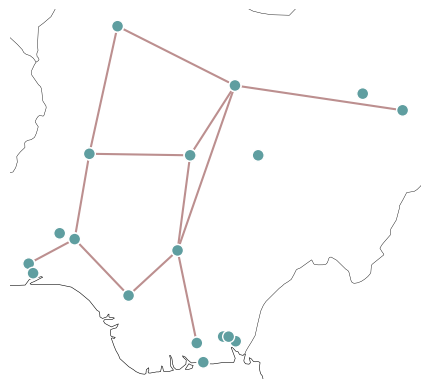

In [9]:
n.plot()

In [10]:
# temporal resolution - timesteps
len(n.snapshots)

48

### Overview components

In [11]:
for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name, len(c.df)))

Component 'Bus' has 54 entries
Component 'Carrier' has 18 entries
Component 'GlobalConstraint' has 1 entries
Component 'Line' has 12 entries
Component 'LineType' has 33 entries
Component 'TransformerType' has 14 entries
Component 'Link' has 72 entries
Component 'Load' has 18 entries
Component 'Generator' has 63 entries
Component 'StorageUnit' has 38 entries
Component 'Store' has 36 entries


### Energy balance

In [12]:
n.stores_t.p.sum()

Store
NG0 0 H2         0.000000e+00
NG0 0 battery    0.000000e+00
NG0 1 H2         0.000000e+00
NG0 1 battery    0.000000e+00
NG0 2 H2         0.000000e+00
NG0 2 battery    0.000000e+00
NG0 3 H2         0.000000e+00
NG0 3 battery    0.000000e+00
NG0 4 H2         0.000000e+00
NG0 4 battery    0.000000e+00
NG0 5 H2         0.000000e+00
NG0 5 battery    0.000000e+00
NG0 6 H2         0.000000e+00
NG0 6 battery    0.000000e+00
NG0 7 H2        -1.893266e-29
NG0 7 battery    0.000000e+00
NG0 8 H2         0.000000e+00
NG0 8 battery    0.000000e+00
NG0 9 H2         0.000000e+00
NG0 9 battery    0.000000e+00
NG1 0 H2         1.110000e-06
NG1 0 battery    0.000000e+00
NG2 0 H2         0.000000e+00
NG2 0 battery    0.000000e+00
NG3 0 H2         0.000000e+00
NG3 0 battery    0.000000e+00
NG4 0 H2        -2.300000e-06
NG4 0 battery    0.000000e+00
NG5 0 H2         2.890000e-06
NG5 0 battery    0.000000e+00
NG6 0 H2        -1.490000e-06
NG6 0 battery    0.000000e+00
NG7 0 H2        -2.140000e-06
NG7 

In [13]:
# Difference between total load and generation
# losses = n.stores_t
n.generators_t.p.sum().sum() - n.loads_t.p.sum().sum()  # - substract storage losses

253272.7321039894

### Total installed generator capacity

In [14]:
gen_cap = n.generators.groupby(["carrier"]).p_nom_opt.sum()
gen_cap

carrier
CCGT      4.500000e+02
OCGT      6.021930e+03
load      1.800000e+10
oil       1.222763e+03
onwind    1.259113e+03
solar     1.084017e+04
Name: p_nom_opt, dtype: float64

In [15]:
n.stores_t.p.head()

Store,NG0 0 H2,NG0 0 battery,NG0 1 H2,NG0 1 battery,NG0 2 H2,NG0 2 battery,NG0 3 H2,NG0 3 battery,NG0 4 H2,NG0 4 battery,NG0 5 H2,NG0 5 battery,NG0 6 H2,NG0 6 battery,NG0 7 H2,NG0 7 battery,NG0 8 H2,NG0 8 battery,NG0 9 H2,NG0 9 battery,NG1 0 H2,NG1 0 battery,NG2 0 H2,NG2 0 battery,NG3 0 H2,NG3 0 battery,NG4 0 H2,NG4 0 battery,NG5 0 H2,NG5 0 battery,NG6 0 H2,NG6 0 battery,NG7 0 H2,NG7 0 battery,NG8 0 H2,NG8 0 battery
snapshot,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000e+00,-0.000000e+00,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,26.526715,0.0,0.0,0.0,0.0,0.0,14.624693,0.0,19.264453,0.0,5.422136,0.0,-0.000000e+00,-0.000000e+00,-10.615319,0.0
2013-01-01 03:00:00,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000e+00,-0.000000e+00,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,30.053817,0.0,0.0,0.0,0.0,0.0,15.635936,0.0,21.824107,0.0,6.142572,0.0,-0.000000e+00,-0.000000e+00,10.615319,0.0
2013-01-01 06:00:00,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000e+00,-0.000000e+00,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,0.0,0.0,0.0,0.0,0.0,3.385503,0.0,3.340539,0.0,1.060287,0.0,-0.000000e+00,-0.000000e+00,-0.000000,0.0
2013-01-01 09:00:00,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-1.050497e-14,-1.050497e-14,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-53.065302,0.0,0.0,0.0,0.0,0.0,-26.936033,0.0,-23.960609,0.0,-6.637500,0.0,1.050497e-14,-0.000000e+00,-226.362860,0.0
2013-01-01 12:00:00,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.050497e-14,1.050497e-14,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-55.897644,0.0,0.0,0.0,0.0,0.0,-28.658126,0.0,-50.106758,0.0,-14.195127,0.0,1.050497e-14,-6.144206e-14,-309.033290,0.0


<AxesSubplot: xlabel='snapshot'>

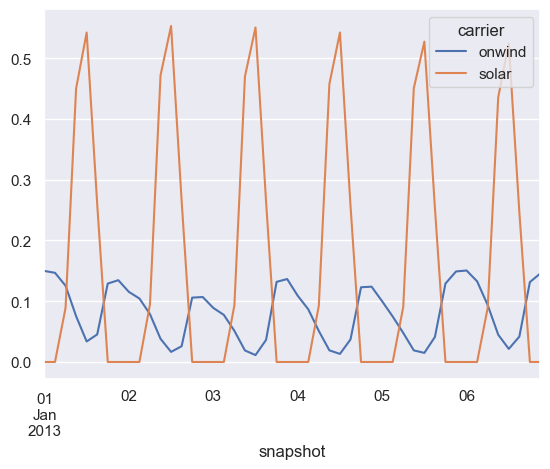

In [16]:
n.generators_t.p_max_pu.groupby(n.generators.carrier, axis=1).mean().plot()

In [17]:
# If 0, all renewable capacity potential is used
n.generators.p_nom_max.sum() - n.generators.p_nom_opt.sum()

inf

In [18]:
n.loads_t.p.sum().sum()

256012.19086166465

In [19]:
n.generators_t.p.sum().sum()

509284.92296565406

In [20]:
n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom_opt.sum() * 0.0000003

bus    carrier
NG0 0  OCGT         0.000684
       load       300.000000
       onwind       0.000000
       solar        0.000000
NG0 1  load       300.000000
                     ...    
NG7 0  onwind       0.000083
       solar        0.000065
NG8 0  load       300.000000
       onwind       0.000290
       solar        0.000420
Name: p_nom_opt, Length: 63, dtype: float64

~/opt/miniconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/plot.py:259: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, ratio in ratios.iteritems():


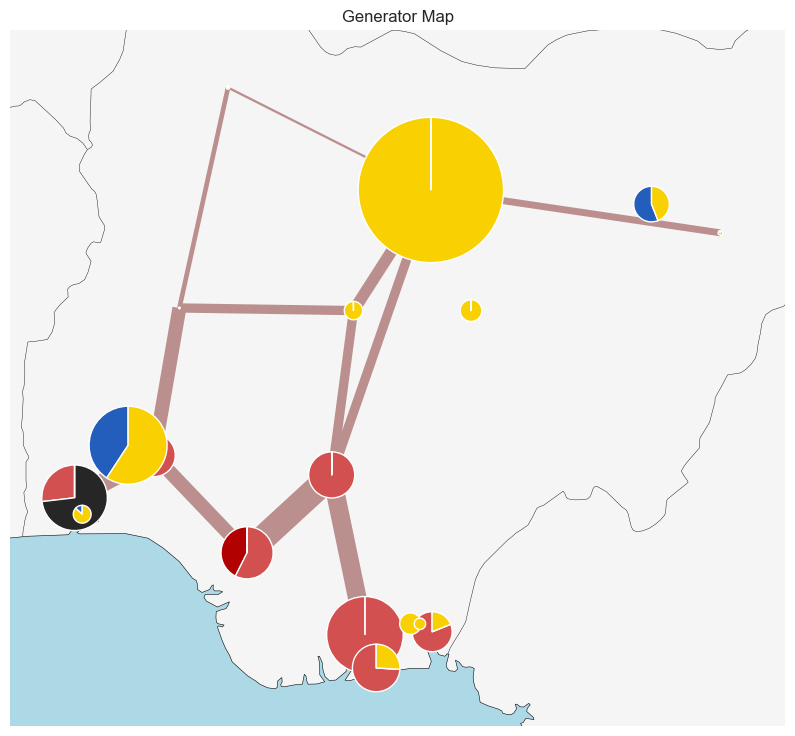

In [21]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

# loading = (n3.lines_t.p0.abs().mean().sort_index() / (n3.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.generators[n.generators.carrier != "load"].iloc[:, :].groupby(["bus", "carrier"]).p_nom_opt.sum()
    ),
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3e2,
    link_widths=1.5,
    transformer_widths=1.5,
    #line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Generator Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off");

### Demand

In [22]:
type(n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum())

pandas.core.series.Series

<AxesSubplot: xlabel='snapshot'>

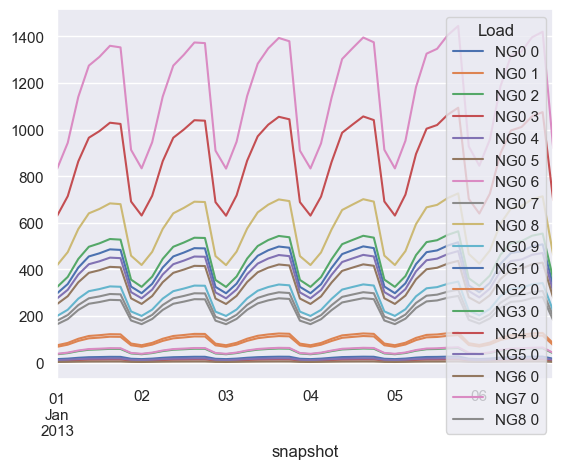

In [23]:
n.loads_t.p.loc["2013-01-01":"2013-01-07"].plot()

In [24]:
type(n.loads_t.p_set.sum())

pandas.core.series.Series

In [25]:
a = n.loads_t.p_set.sum().rename("load").rename_axis("bus")
a.rename("load", inplace=True)
a.rename_axis("bus", inplace=True)
a

bus
NG0 0    19884.352861
NG0 1     5001.321718
NG0 2    21695.168362
NG0 3    42095.505997
NG0 4    18430.873216
NG0 5    16813.393316
NG0 6    55590.164031
NG0 7    11026.500524
NG0 8    27950.022971
NG0 9    13385.712457
NG1 0     1027.951158
NG2 0     4559.622065
NG3 0     2429.803347
NG4 0      566.131303
NG5 0      745.739410
NG6 0      209.894414
NG7 0     2548.672761
NG8 0    12051.360951
Name: load, dtype: float64

In [26]:
n.loads_t.p_set.sum().rename("load").rename_axis("bus")

bus
NG0 0    19884.352861
NG0 1     5001.321718
NG0 2    21695.168362
NG0 3    42095.505997
NG0 4    18430.873216
NG0 5    16813.393316
NG0 6    55590.164031
NG0 7    11026.500524
NG0 8    27950.022971
NG0 9    13385.712457
NG1 0     1027.951158
NG2 0     4559.622065
NG3 0     2429.803347
NG4 0      566.131303
NG5 0      745.739410
NG6 0      209.894414
NG7 0     2548.672761
NG8 0    12051.360951
Name: load, dtype: float64

In [27]:
n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum()

bus
NG0 0    1.000002e+09
NG0 1    1.000000e+09
NG0 2    1.000001e+09
NG0 3    1.000008e+09
NG0 4    1.000000e+09
NG0 5    1.000000e+09
NG0 6    1.000001e+09
NG0 7    1.000000e+09
NG0 8    1.000002e+09
NG0 9    1.000001e+09
NG1 0    1.000000e+09
NG2 0    1.000001e+09
NG3 0    1.000001e+09
NG4 0    1.000000e+09
NG5 0    1.000000e+09
NG6 0    1.000000e+09
NG7 0    1.000000e+09
NG8 0    1.000002e+09
Name: p_nom_opt, dtype: float64

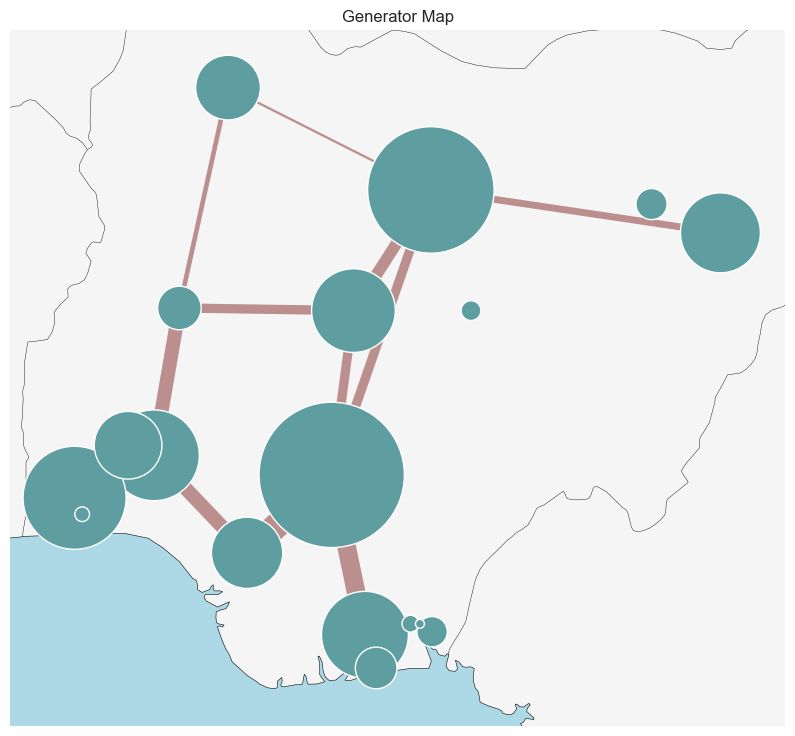

In [28]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        # PlateCarree(default), Mercator, Orthographic
        "projection": ccrs.PlateCarree()
    },  
)

# loading = (n3.lines_t.p0.abs().mean().sort_index() / (n3.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.loads_t.p_set.sum().rename("load").rename_axis("bus")
    ),  # n.loads_t.p_set.sum().rename("load").rename_axis("bus")*.0000003,
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Generator Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off");

In [29]:
# backup
gen_serie = n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom_opt.sum()
load_serie = n.loads_t.p_set.sum().rename("load").rename_axis("bus")

load_serie = pd.Series(
    load_serie.values,
    index=pd.MultiIndex.from_tuples([(id, "AC load") for id in load_serie.index]),
)

tot_serie = pd.concat([gen_serie, load_serie])  # .groupby(['bus', 'carrier']).sum()

pd.concat([gen_serie, load_serie])

bus    carrier
NG0 0  OCGT       2.278775e+03
       load       1.000000e+09
       onwind     0.000000e+00
       solar      0.000000e+00
NG0 1  load       1.000000e+09
                      ...     
NG4 0  AC load    5.661313e+02
NG5 0  AC load    7.457394e+02
NG6 0  AC load    2.098944e+02
NG7 0  AC load    2.548673e+03
NG8 0  AC load    1.205136e+04
Length: 81, dtype: float64

### Plot of Average Marginal Price

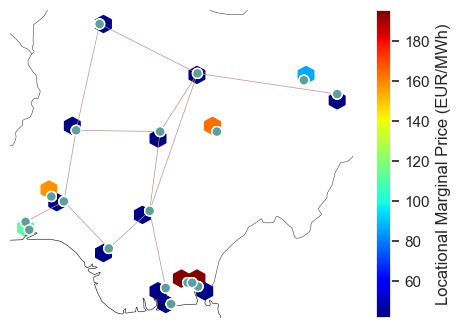

In [30]:
now = n.snapshots[4]  # one specific time

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(6, 4)

n.plot(ax=ax, line_widths=pd.Series(0.5, n.lines.index))
plt.hexbin(
    n.buses.x,
    n.buses.y,
    gridsize=20,
    # C=n.buses_t.marginal_price.loc[now], #at one time (previous set up by scigrid)
    C=n.buses_t.marginal_price.sum()
    / len(n.snapshots[:]),  # Marginal price averaged over the whole year (My version)
    # - shows in which regions electricity will be cheap and where el. intensive companies should be placed.
    cmap=plt.cm.jet,
)

# for some reason the colorbar only works with graphs plt.plot
# and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label("Locational Marginal Price (EUR/MWh)")

### Storage

<AxesSubplot: xlabel='snapshot'>

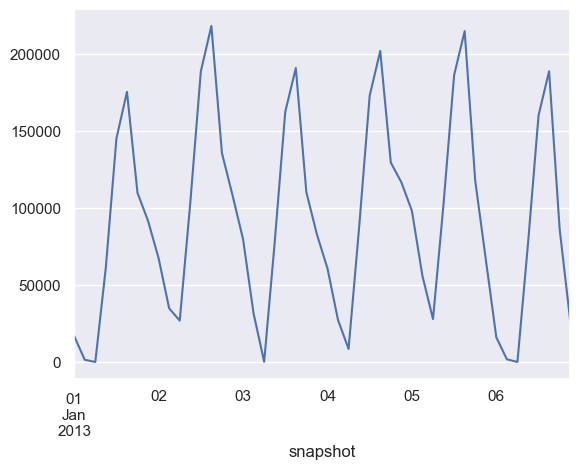

In [31]:
n.stores_t.e.loc["2013-01-01":"2013-01-07"].sum(axis=1).plot()

In [32]:
n.links.iloc[:].groupby(["carrier"]).p_nom_opt.sum()

carrier
H2 electrolysis       585.470237
H2 fuel cell          577.278320
battery charger         0.000000
battery discharger      0.000000
Name: p_nom_opt, dtype: float64